In [96]:
import sys
from collections import defaultdict
import cv2
import numpy as np
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

In [97]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from IPython.display import Video

In [98]:
import wandb

# Initialize wandb
wandb.init(project='Faster_RCNN', name='Optimized_run')


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
epoch_loss,█▆▅▄▃▂▂▂▂▁
loss,▁▁▁▁▁▁▁▆▅▁▂▁▁█▁▆▁▁▂▁▄▁▁▁▁▁▁▄▁▅▁▁▁▁▁▁▁▁▁▁
lr,▁▁
momentum,▁▁
epoch,1
epoch_loss,4.38695
loss,5.38131
lr,0.001
momentum,0.9


In [99]:
!pip install -U ipywidgets

In [100]:
#Data Annotation Change

In [101]:
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
import yaml

# Define the dataset path
dataset_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset'
dataset_path2 = '/kaggle/working/FasterRCNN_data2'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
print(yaml.dump(yaml_content, default_flow_style=False))

# Paths for YOLO and VOC format
yolo_train_path = os.path.join(dataset_path, 'train', 'images')
yolo_train_labels_path = os.path.join(dataset_path, 'train', 'labels')
yolo_valid_path = os.path.join(dataset_path, 'valid', 'images')
yolo_valid_labels_path = os.path.join(dataset_path, 'valid', 'labels')

voc_train_path = os.path.join(dataset_path2, 'train')
voc_train_images_path = os.path.join(voc_train_path, 'images')
voc_train_annotations_path = os.path.join(voc_train_path, 'annotations')

voc_valid_path = os.path.join(dataset_path2, 'valid')
voc_valid_images_path = os.path.join(voc_valid_path, 'images')
voc_valid_annotations_path = os.path.join(voc_valid_path, 'annotations')

# Create the VOC directory structure
os.makedirs(voc_train_images_path, exist_ok=True)
os.makedirs(voc_train_annotations_path, exist_ok=True)
os.makedirs(voc_valid_images_path, exist_ok=True)
os.makedirs(voc_valid_annotations_path, exist_ok=True)

# Convert YOLO annotations to PASCAL VOC format
for filename in os.listdir(yolo_train_labels_path):
    if filename.endswith('.txt'):
        image_filename = os.path.splitext(filename)[0] + '.jpg'
        image_path = os.path.join(yolo_train_path, image_filename)
        image = Image.open(image_path)
        width, height = image.size

        with open(os.path.join(yolo_train_labels_path, filename), 'r') as f:
            lines = f.readlines()

        root = ET.Element('annotation')
        ET.SubElement(root, 'filename').text = image_filename
        size = ET.SubElement(root, 'size')
        ET.SubElement(size, 'width').text = str(width)
        ET.SubElement(size, 'height').text = str(height)
        depth = image.getbands()
        ET.SubElement(size, 'depth').text = str(len(depth))

        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width_norm = float(values[3])
            height_norm = float(values[4])

            # Calculate bounding box coordinates
            x_min = int((x_center - width_norm / 2) * width)
            y_min = int((y_center - height_norm / 2) * height)
            x_max = int((x_center + width_norm / 2) * width)
            y_max = int((y_center + height_norm / 2) * height)

            obj = ET.SubElement(root, 'object')
            ET.SubElement(obj, 'name').text = yaml_content['names'][class_id]
            bndbox = ET.SubElement(obj, 'bndbox')
            ET.SubElement(bndbox, 'xmin').text = str(x_min)
            ET.SubElement(bndbox, 'ymin').text = str(y_min)
            ET.SubElement(bndbox, 'xmax').text = str(x_max)
            ET.SubElement(bndbox, 'ymax').text = str(y_max)

        tree = ET.ElementTree(root)
        tree.write(os.path.join(voc_train_annotations_path, os.path.splitext(filename)[0] + '.xml'))
        shutil.copy(image_path, os.path.join(voc_train_images_path, image_filename))

# Repeat the same process for the validation set
for filename in os.listdir(yolo_valid_labels_path):
    if filename.endswith('.txt'):
        image_filename = os.path.splitext(filename)[0] + '.jpg'
        image_path = os.path.join(yolo_valid_path, image_filename)
        image = Image.open(image_path)
        width, height = image.size

        with open(os.path.join(yolo_valid_labels_path, filename), 'r') as f:
            lines = f.readlines()

        root = ET.Element('annotation')
        ET.SubElement(root, 'filename').text = image_filename
        size = ET.SubElement(root, 'size')
        ET.SubElement(size, 'width').text = str(width)
        ET.SubElement(size, 'height').text = str(height)
        depth = image.getbands()
        ET.SubElement(size, 'depth').text = str(len(depth))

        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width_norm = float(values[3])
            height_norm = float(values[4])

            # Calculate bounding box coordinates
            x_min = int((x_center - width_norm / 2) * width)
            y_min = int((y_center - height_norm / 2) * height)
            x_max = int((x_center + width_norm / 2) * width)
            y_max = int((y_center + height_norm / 2) * height)

            obj = ET.SubElement(root, 'object')
            ET.SubElement(obj, 'name').text = yaml_content['names'][class_id]
            bndbox = ET.SubElement(obj, 'bndbox')
            ET.SubElement(bndbox, 'xmin').text = str(x_min)
            ET.SubElement(bndbox, 'ymin').text = str(y_min)
            ET.SubElement(bndbox, 'xmax').text = str(x_max)
            ET.SubElement(bndbox, 'ymax').text = str(y_max)

        tree = ET.ElementTree(root)
        tree.write(os.path.join(voc_valid_annotations_path, os.path.splitext(filename)[0] + '.xml'))
        shutil.copy(image_path, os.path.join(voc_valid_images_path, image_filename))

print("Conversion to PASCAL VOC format completed.")


names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images

Conversion to PASCAL VOC format completed.


In [102]:
dataset_path2

'/kaggle/working/FasterRCNN_data2'

In [103]:
train_images_path = os.path.join(dataset_path2, 'train', 'images')

In [104]:
train_images_path = os.path.join(dataset_path2, 'train', 'images')
valid_images_path = os.path.join(dataset_path2, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


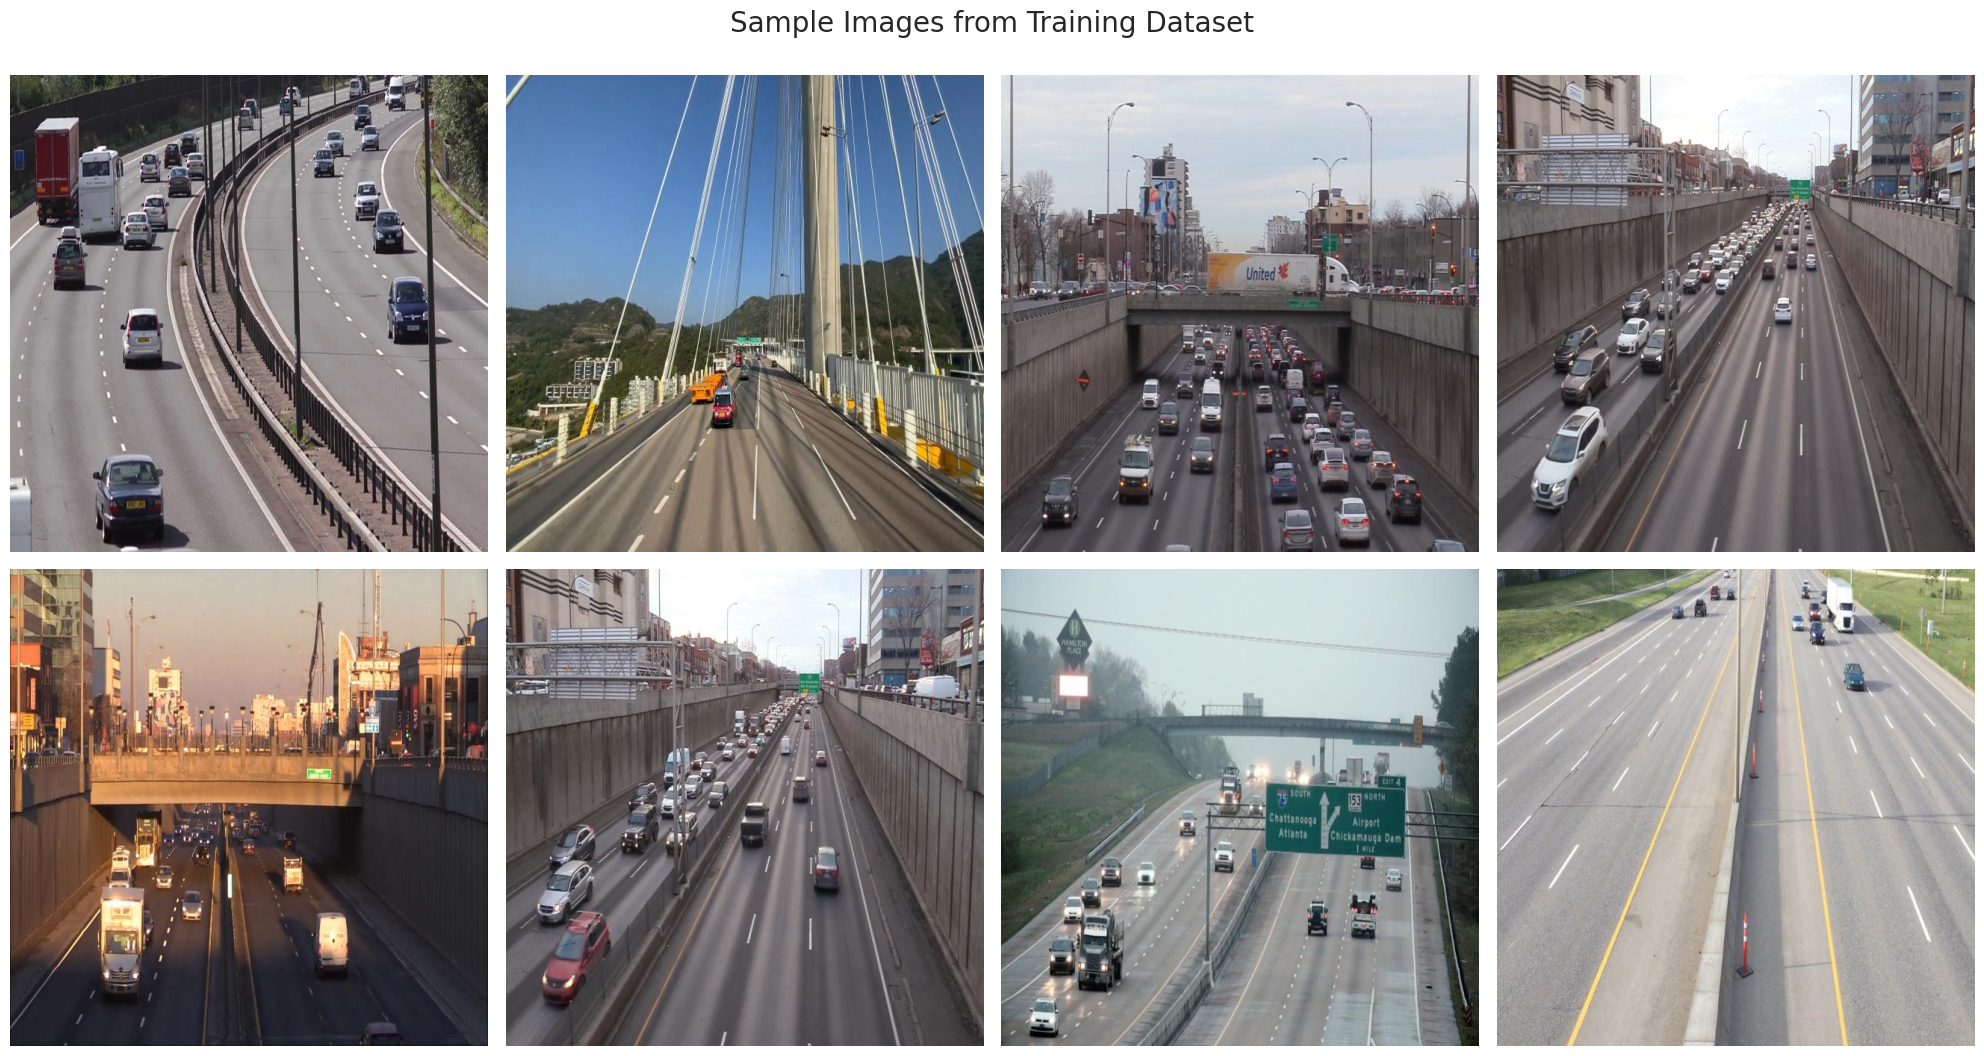

In [105]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')  

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [106]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

In [107]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

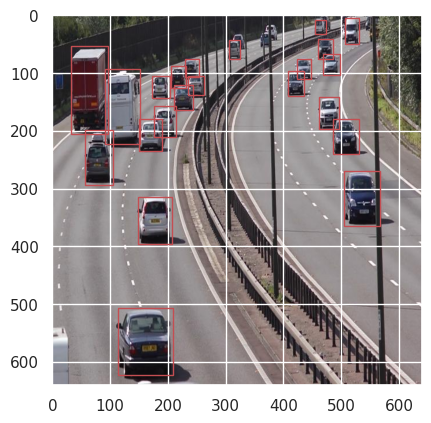

In [108]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, mode):
        self.root_dir = root_dir
        self.mode = mode
        self.image_dir = os.path.join(root_dir, mode, 'images')
        self.annotation_dir = os.path.join(root_dir, mode, 'annotations')
        self.image_files = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
        annotation_path = os.path.join(self.annotation_dir, annotation_filename)
        try:
            bboxes, labels = self.load_annotations(annotation_path)
        except Exception as e:
            print(f"Error loading annotations for {image_filename}: {e}")
            return None

        # Create figure and axes
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        # Add bounding boxes
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.show()

        return image, {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

    def load_annotations(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        bboxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Check if bounding box coordinates are valid
            if xmax <= xmin or ymax <= ymin:
                raise ValueError(f"Invalid bounding box coordinates for {name} in {annotation_path}")

            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming all objects are of the same class

        return bboxes, labels

# Test the dataset
dataset = CustomDataset('/kaggle/working/FasterRCNN_data', 'train')
image, target = dataset[0]  # Visualize the first image with its bounding boxes


In [109]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.optim as optim
import torchvision.models.detection as detection
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, img_size=416):
        self.root_dir = root_dir
        self.mode = mode
        self.image_dir = os.path.join(root_dir, mode, 'images')
        self.annotation_dir = os.path.join(root_dir, mode, 'annotations')
        self.image_files = os.listdir(self.image_dir)
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        annotation_filename = os.path.splitext(image_filename)[0] + '.xml'
        annotation_path = os.path.join(self.annotation_dir, annotation_filename)
        try:
            bboxes, labels = self.load_annotations(annotation_path)
        except Exception as e:
            print(f"Error loading annotations for {image_filename}: {e}")
            return None

        # Apply transformations
        image = self.transform(image)

        return image, {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

    def load_annotations(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        bboxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Check if bounding box coordinates are valid
            if xmax <= xmin or ymax <= ymin:
                raise ValueError(f"Invalid bounding box coordinates for {name} in {annotation_path}")

            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming all objects are of the same class

        return bboxes, labels

# Define the dataset
dataset = CustomDataset('/kaggle/working/FasterRCNN_data', 'train')

# Define the model


In [110]:
# model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # Define optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Training loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# num_epochs = 10
# for epoch in range(num_epochs):
#     print(epoch)
#     model.train()
#     running_loss = 0.0
#     for images, targets in dataset:
#         optimizer.zero_grad()
#         images = images.unsqueeze(0).to(device)  # Add batch dimension and send images to GPU if available
#         targets = [{k: v.to(device) for k, v in targets.items()}]  # Convert targets to list of dictionaries and send to GPU if available

#         # Forward pass
#         loss_dict = model(images, targets)

#         # Compute total loss
#         total_loss = sum(loss for loss in loss_dict.values())
        
#         # Backward pass
#         total_loss.backward()
#         optimizer.step()

#         running_loss += total_loss.item()
#         wandb.log({'epoch': epoch, 'loss': total_loss.item()})
#     wandb.log({'epoch_loss': running_loss / len(dataset)})

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataset)}")


In [111]:
# model.eval()

# for i in range(len(dataset)):
#     image, target = dataset[i]  # Get an image and its target
#     with torch.no_grad():
#         prediction = model([image])  # Perform inference

#     # Visualize the image with its bounding boxes and predicted bounding boxes
#     fig, ax = plt.subplots(1)
#     ax.imshow(image.permute(1, 2, 0))  # Convert tensor to image format (H, W, C)

#     # Add ground truth bounding boxes
#     for bbox in target['boxes']:
#         xmin, ymin, xmax, ymax = bbox
#         rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
#         ax.add_patch(rect)

#     # Add predicted bounding boxes
#     for bbox in prediction[0]['boxes']:
#         xmin, ymin, xmax, ymax = bbox.cpu().numpy()
#         rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)

#     plt.show()

In [112]:
#  checkpoint_path = f"model_epoch_{epoch+1}.pth"
# torch.save(model.state_dict(), checkpoint_path)
# print(f"Model saved at {checkpoint_path}")

In [113]:
import torch.optim as optim
import itertools

# Define hyperparameters grid
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.9, 0.95, 0.99]

# Grid search loop
for lr, momentum in itertools.product(learning_rates, momentums):
    # Define model and optimizer with current hyperparameters
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in dataset:
            optimizer.zero_grad()
            images = images.unsqueeze(0).to(device)  # Add batch dimension and send images to GPU if available
            targets = [{k: v.to(device) for k, v in targets.items()}]  # Convert targets to list of dictionaries and send to GPU if available

            # Forward pass
            loss_dict = model(images, targets)

            # Compute total loss
            total_loss = sum(loss for loss in loss_dict.values())
            
            # Backward pass
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # Log loss to wandb
        wandb.log({'lr': lr, 'momentum': momentum, 'epoch': epoch, 'loss': running_loss / len(dataset)})

    print(f"Hyperparameters: lr={lr}, momentum={momentum}, Final Loss: {running_loss/len(dataset)}")


Hyperparameters: lr=0.001, momentum=0.9, Final Loss: 4.479326890573017
Hyperparameters: lr=0.001, momentum=0.95, Final Loss: nan
Hyperparameters: lr=0.001, momentum=0.99, Final Loss: nan
Hyperparameters: lr=0.01, momentum=0.9, Final Loss: nan
Hyperparameters: lr=0.01, momentum=0.95, Final Loss: nan
Hyperparameters: lr=0.01, momentum=0.99, Final Loss: nan
Hyperparameters: lr=0.1, momentum=0.9, Final Loss: nan
Hyperparameters: lr=0.1, momentum=0.95, Final Loss: nan
Hyperparameters: lr=0.1, momentum=0.99, Final Loss: nan
